In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost

In [35]:
df = pd.read_csv('./train_test_data/prepared_training_data.csv',index_col='id')

test_df = pd.read_csv('./train_test_data/prepared_test_data.csv',index_col='id')
#df.drop(columns='permit',inplace=True)
#test_df.drop(columns='permit',inplace=True)


In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier, plot_importance, plot_tree

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score,f1_score,cohen_kappa_score,plot_confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_selection import RFECV

In [37]:
# set X and y variables
X = df.drop(columns=['status_group','population'])
Y = df.status_group

# get list of predictors to OHE
object_predictors = list(X.select_dtypes(include=['object']).columns)
test_object_predictors = list(test_df.select_dtypes(include=['object']).columns)

In [38]:
# Check Columns are good
X.columns

Index(['date_recorded', 'gps_height', 'longitude', 'latitude', 'region',
       'district_code', 'scheme_management', 'permit', 'extraction_type',
       'management', 'quality_group', 'quantity', 'source_type',
       'waterpoint_type', 'tsh_bins', 'top_funders', 'top_installers',
       'population_size', 'construction_decade'],
      dtype='object')

In [39]:
# Check columns are good
test_df.columns

Index(['date_recorded', 'gps_height', 'longitude', 'latitude', 'region',
       'district_code', 'scheme_management', 'permit', 'extraction_type',
       'management', 'quality_group', 'quantity', 'source_type',
       'waterpoint_type', 'tsh_bins', 'top_funders', 'top_installers',
       'population_size', 'construction_decade'],
      dtype='object')

In [40]:
 # Make Column transformer for object columns and ignore the rest
column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), object_predictors),
    remainder='passthrough')

 # Make Column transformer for object columns and ignore the rest
test_column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), test_object_predictors),
    remainder='passthrough')

# Fit column transformers
X = column_trans.fit_transform(X)
test_data = column_trans.transform(test_df)

In [41]:
print(X.shape)

print(test_data.shape)

(59400, 122)
(14850, 122)


### Train Test Split

In [42]:
# Train test split for model training data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size=.2,
    random_state=0)

In [43]:
# tune the model
n_estimators_1 = [200,300]
max_depth_1 = [15,20]
learning_rate_1 = [0.1]
min_child_weight_1 = [1]
reg_lamba_1 = [20,25]
subsample_1 = [0.75,1]

# Create dictionary of parameters to search
param_grid = dict(max_depth=max_depth_1,
                  n_estimators=n_estimators_1,
                  learning_rate=learning_rate_1,
                  min_child_weight=min_child_weight_1,
                  reg_lambda=reg_lamba_1,
                  subsample=subsample_1,
                 )

In [44]:
# Cross Validate and gridsearch
clf = XGBClassifier(objective='multi:softmax',early_stopping_rounds=10)
kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=1)
grid_search = GridSearchCV(clf,param_grid,scoring='accuracy',n_jobs=-1,cv=kfold,verbose=1)
grid_result = grid_search.fit(X, Y)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.5min finished


In [45]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.810320 using {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'reg_lambda': 25, 'subsample': 0.75}
0.809529 (0.000999) with: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'reg_lambda': 20, 'subsample': 0.75}
0.808620 (0.001044) with: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'reg_lambda': 20, 'subsample': 1}
0.810320 (0.001022) with: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'reg_lambda': 25, 'subsample': 0.75}
0.808519 (0.001390) with: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 200, 'reg_lambda': 25, 'subsample': 1}
0.807710 (0.001248) with: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 300, 'reg_lambda': 20, 'subsample': 0.75}
0.809057 (0.001055) with: {'learning_rate': 0.1, 'max_depth': 15, 'min_child_weight': 1, 'n_estimators': 300, 'reg_lambda': 20, '

<Figure size 720x720 with 0 Axes>

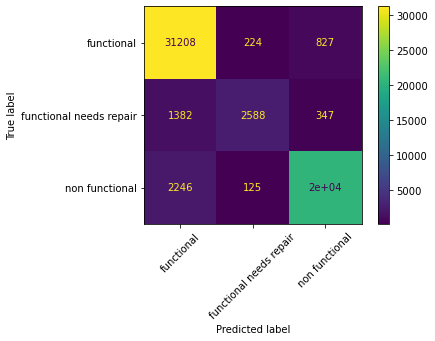

<Figure size 720x720 with 0 Axes>

In [46]:
# Plot Confusion matrix to see how best estimator does
plot_confusion_matrix(grid_result.best_estimator_, X, Y)
plt.xticks(rotation=45)
plt.figure(figsize=(10,10))

In [47]:
# Make predictions to be submitted
test_preds = grid_result.best_estimator_.predict(test_data)

#### Send Test to CSV to submit

In [48]:
# View normalized breakdown of data to check ratios
pd.Series(test_preds).value_counts(normalize=True)*100

functional                 59.973064
non functional             35.993266
functional needs repair     4.033670
dtype: float64

In [49]:
# Check DF
test_df.reset_index(inplace=True)
test_df['status_group'] = test_preds
submit_df = test_df[['id','status_group']]

In [50]:
submit_df.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [51]:
pd.DataFrame.to_csv(submit_df,path_or_buf='./Predictions/iteration_7_csv',index=False)

In [52]:
import pickle

# pickle the model.
with open(f'./{grid_result.best_score_:.4}_iteration_5.sav','wb') as f:
     pickle.dump(clf,f)



In [53]:
import pickle
#load it back in to see if everything works
with open('0.8005330203672462_iteration_3.sav', 'rb') as pickle_file:
     clf = pickle.load(pickle_file)

FileNotFoundError: [Errno 2] No such file or directory: '0.8005330203672462_iteration_3.sav'

In [ ]:
clf.predict(test_data)